# Example notebook that accesses a Norpix sequence file, builds up a dask array and subtracts the background image

In [1]:
import skimage.io
import pims
import numpy as np

In [2]:
#open the sequence file
root = '/home/jovyan/shared-data/pbranson/Exp8/Stage1/Run13/'
seq = pims.NorpixSeq(filename=root + 'LongExp/LongExp.seq')

{'time': datetime.datetime(2018, 9, 4, 12, 29, 25, 496000), 'time_float': 1536064165.496, 'gamut': 255}


Frame([[4, 3, 4, ..., 1, 2, 2],
       [3, 3, 3, ..., 2, 3, 3],
       [3, 2, 3, ..., 1, 2, 3],
       ...,
       [2, 3, 3, ..., 1, 3, 1],
       [2, 2, 3, ..., 2, 3, 2],
       [2, 2, 4, ..., 3, 2, 2]], dtype=uint8)
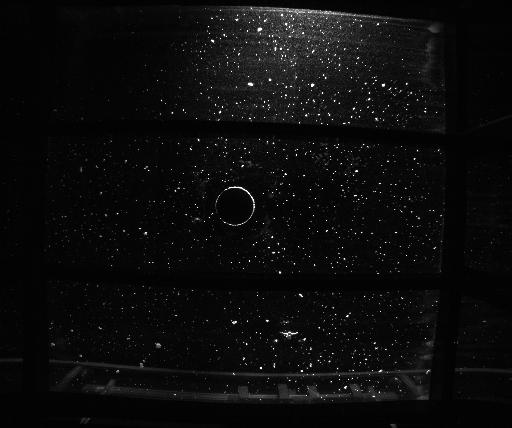

In [3]:
#show a frame
print(seq[2].metadata)
seq[2]

In [4]:
#example of save out some frames
dest = '/home/jovyan/shared-data/pbranson/Exp8/Stage1/Run13/'
for f,frame in enumerate(seq):
    frameTime = frame.metadata['time'].strftime("%Y-%m-%d-%H-%M-%S.%f")[:-3]
    fn = dest + 'frames/%s.tif' %(frameTime)
#         print(fn)
    skimage.io.imsave(arr=frame,fname=fn)
    if f % 100 == 0:
        print(f)
    if f > 10:
        break

0


### The dataset is too large to fit in memory, so makes calculating the minimum image difficult, dask can make this a little more natural than the loops that would otherwise be required, and parallel at the same time

In [5]:
from dask.distributed import Client, LocalCluster
cluster=LocalCluster(n_workers=7,threads_per_worker=1)
client=Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:41133 Dashboard: /user/pbranson/proxy/8787/status,Cluster Workers: 7 Cores: 7 Memory: 22.12 GB


In [6]:
from dask import delayed
import dask.array as da

In [7]:
@delayed
def get_frame(i):
    root = '/home/jovyan/shared-data/pbranson/Exp8/Stage1/Run13/'
    seq = pims.NorpixSeq(filename=root + 'LongExp/LongExp.seq')
    return seq[i]

In [8]:
#lets play with the first 1000 images to get things working, otherwise use the length of the sequence
all_frames = [get_frame(i) for i in range(10000,20000)] #len(seq)

In [9]:
image_arrays = [da.from_delayed(frame,dtype=seq.pixel_type,shape=seq.frame_shape) for frame in all_frames] #make an array from each frame

In [10]:
image_stack = da.stack(image_arrays,axis=0) #stack the small arrays into one
image_stack

dask.array<stack, shape=(10000, 2050, 2448), dtype=uint8, chunksize=(1, 2050, 2448)>

In [11]:
image_stack = image_stack.rechunk((20,2050, 2448)) #rechunk into workable size
image_stack

dask.array<rechunk-merge, shape=(10000, 2050, 2448), dtype=uint8, chunksize=(20, 2050, 2448)>

In [39]:
minimum_image = image_stack.min(axis=0) #the min over the stack

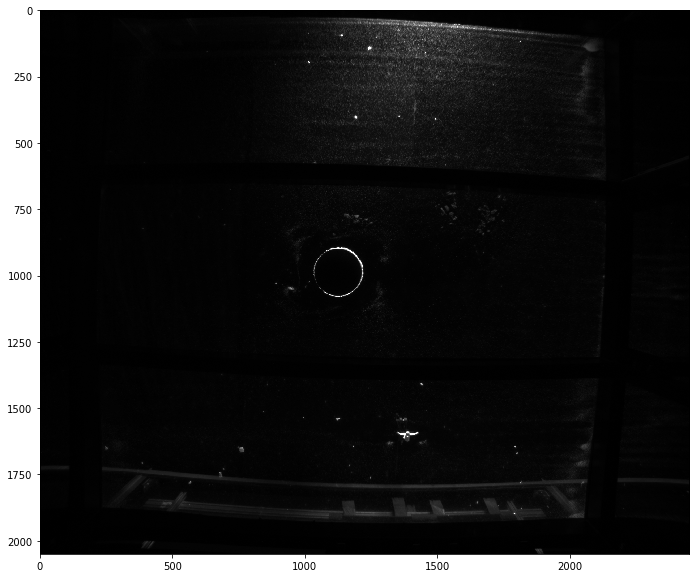

In [13]:
import matplotlib.pyplot as pl
fig,ax = pl.subplots(figsize=(12,10))
ax.imshow(minimum_image,cmap=pl.cm.gray)

In [14]:
#subtract the minimum image from the stack
bg_removed = image_stack - minimum_image

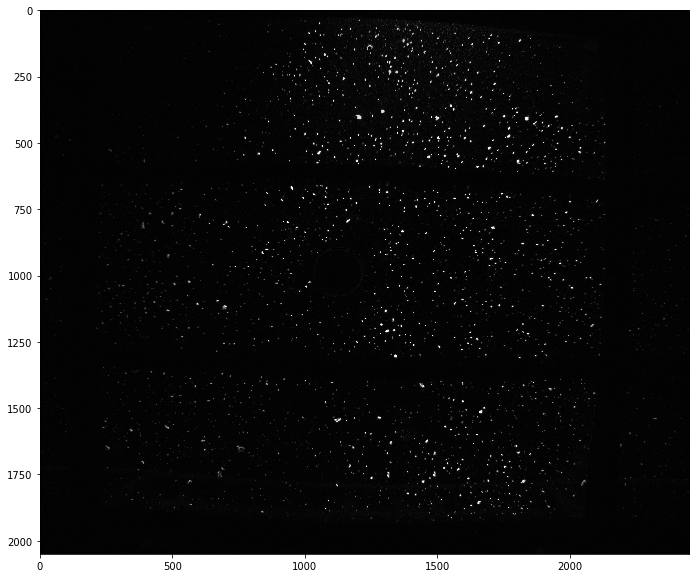

In [15]:
fig,ax = pl.subplots(figsize=(12,10))
ax.imshow(bg_removed[50,:,:],cmap=pl.cm.gray)

### Coarsen the array to make some streak photos

In [12]:
streaks=da.coarsen(np.max,image_stack,{0:20,1:2,2:2},trim_excess=True) #across 20 frames, reduce resolution by 2
# streaks=streaks.persist() #calculate and store across cluster

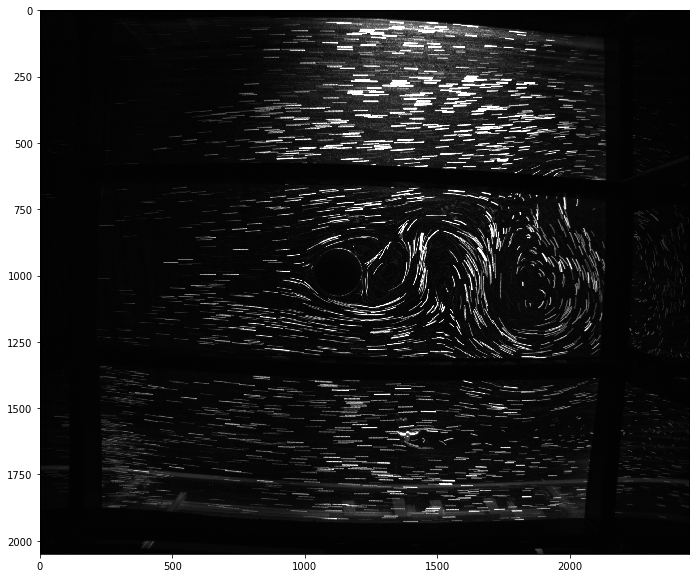

In [52]:
fig,ax = pl.subplots(figsize=(12,10))
ax.imshow(streaks[13,:,:],cmap=pl.cm.gray)

In [ ]:
for i in range(streaks.shape[0]):
    if i % 10 == 0:
        print(i)
    skimage.io.imsave(arr=streaks[i,:,:],fname=dest + 'streaks%05.0f.png' % i)
    

0
10
20
30
40
